In [1]:
using DifferentialEquations, DiffEqProblemLibrary, Plots, Rsvg
gr()

Plots.GRBackend()

# Plot solutions by each method

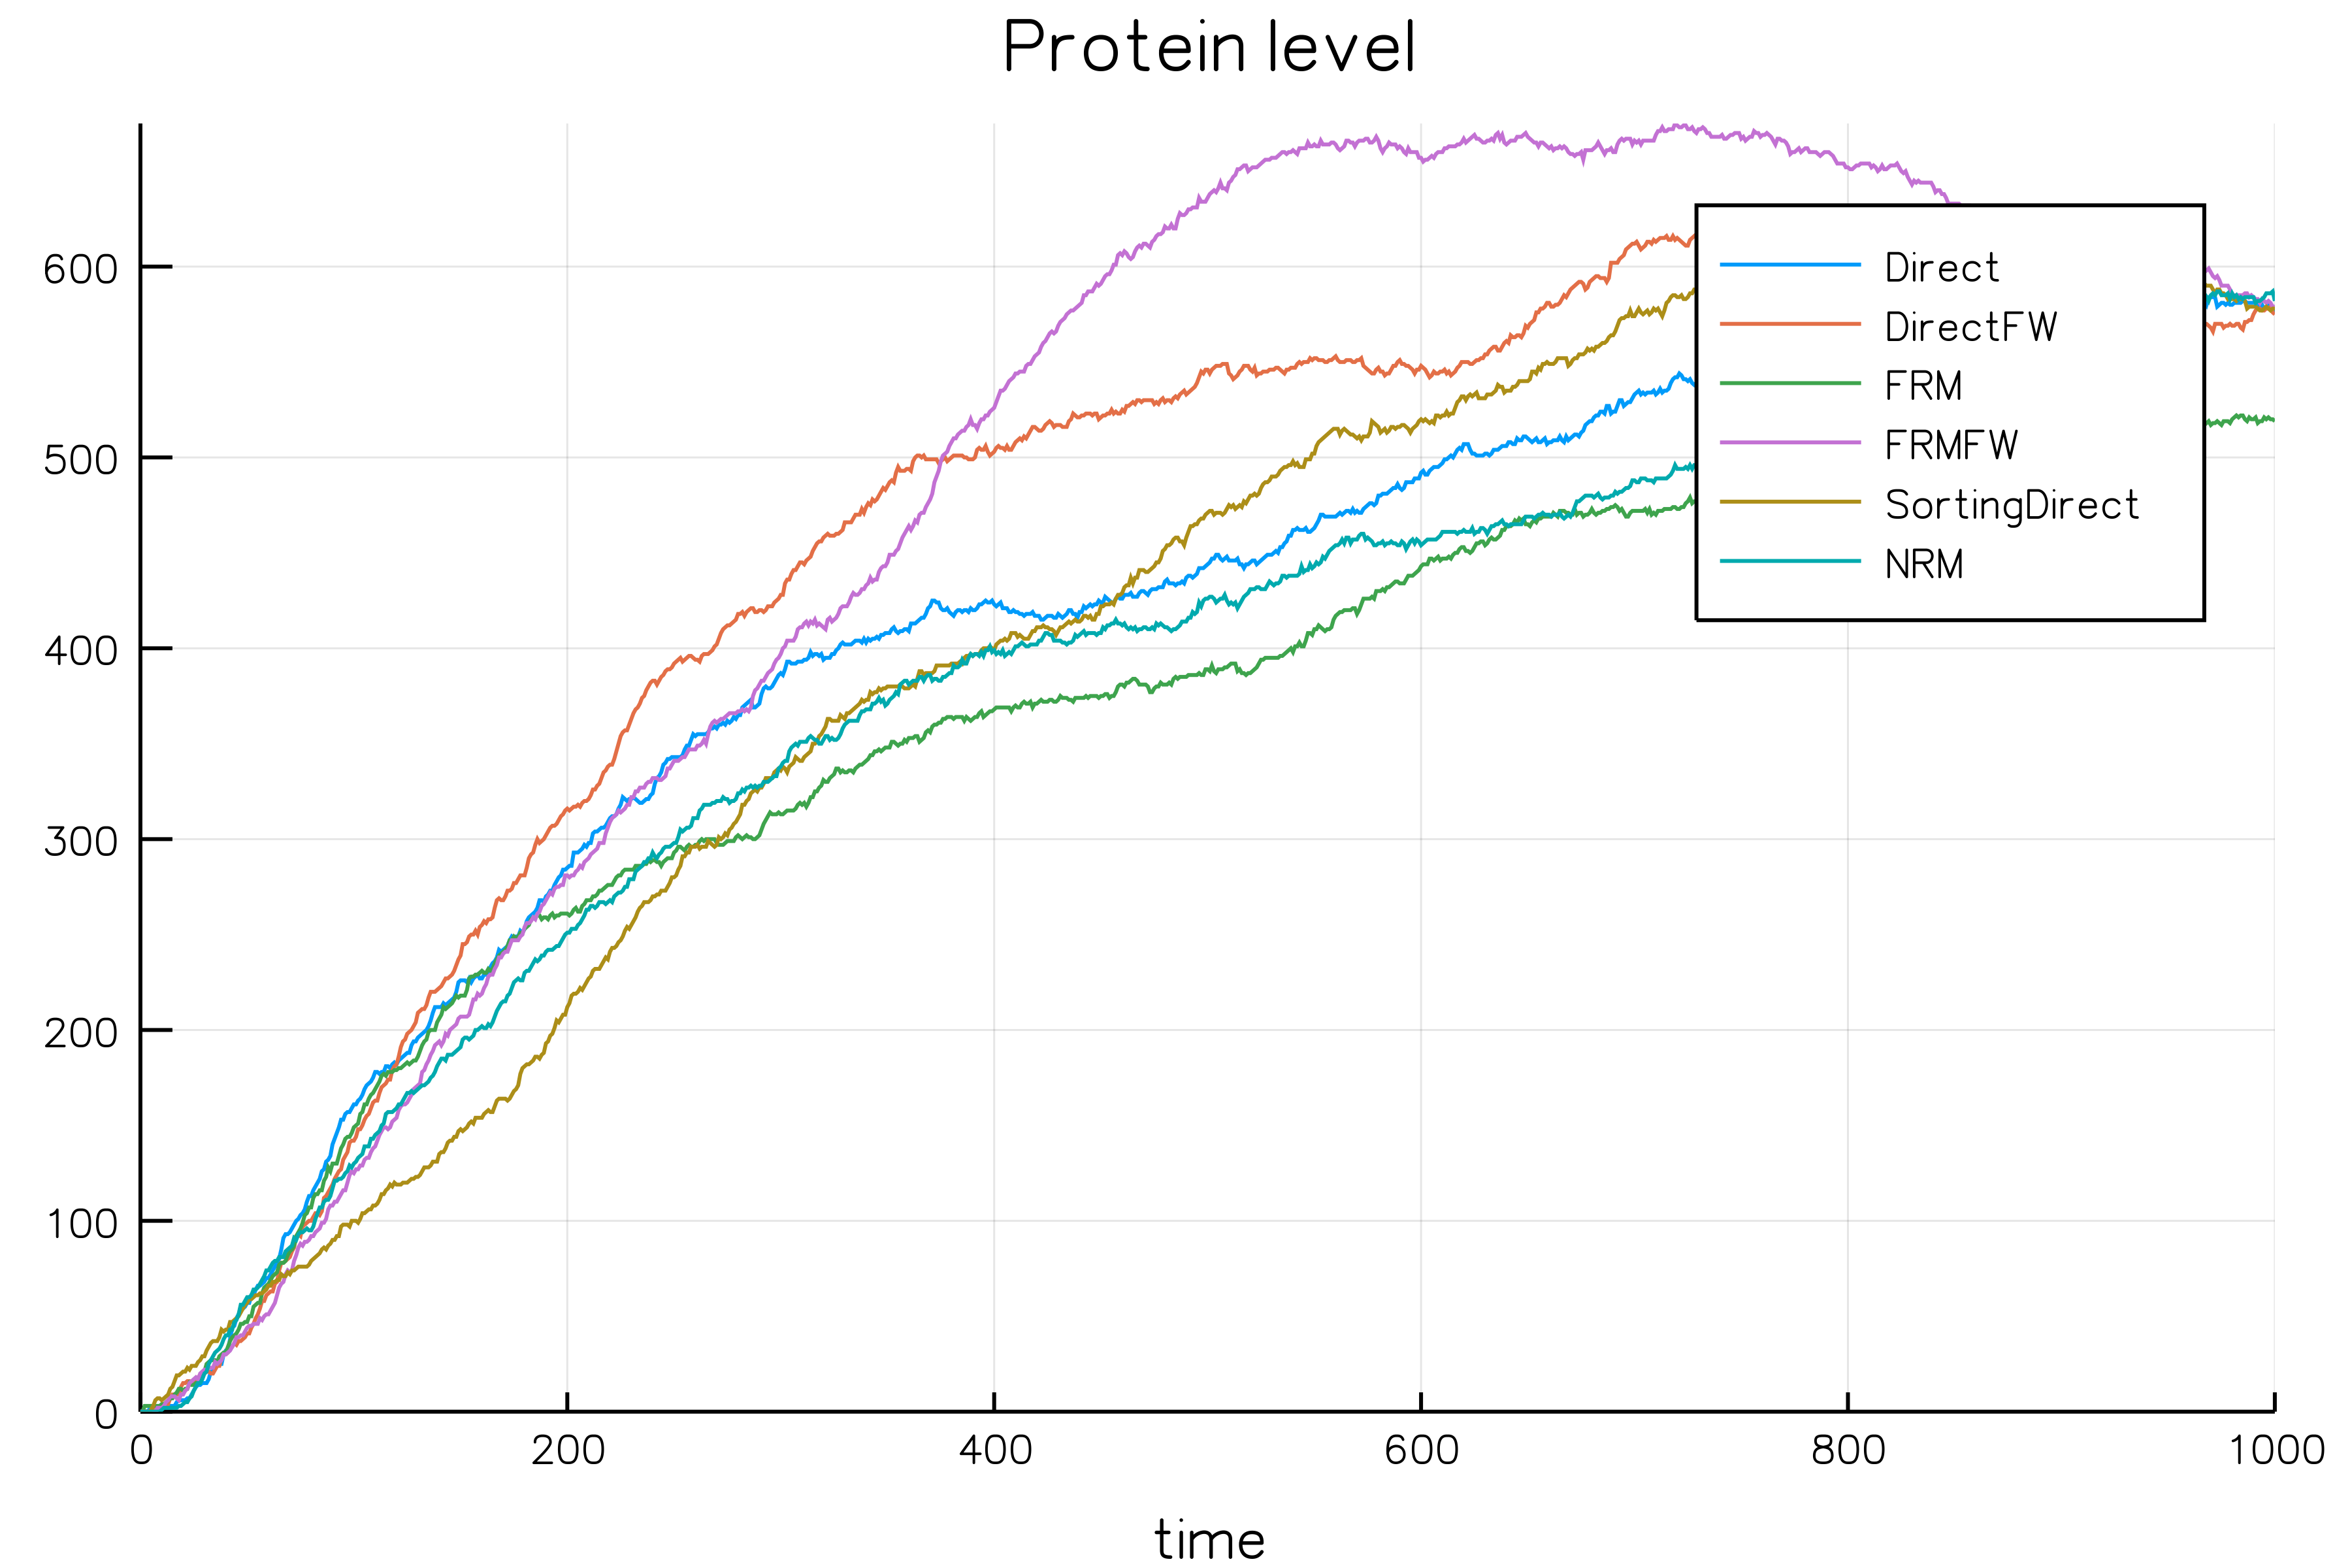

In [2]:
methods = (Direct(),DirectFW(),FRM(),FRMFW(),SortingDirect(),NRM())
legs    = [typeof(method) for method in methods]
shortlabels = [string(leg)[12:end] for leg in legs]
fmt     = :png
prob    = prob_jump_dnarepressor.discrete_prob
tf      = prob_jump_dnarepressor.tstop
rn      = prob_jump_dnarepressor.network
ploth   = plot(reuse=false)
for (i,method) in enumerate(methods)
    jump_prob = JumpProblem(prob, method, rn, save_positions=(false,false))
    sol = solve(jump_prob, SSAStepper(), saveat=tf/1000.)
    plot!(ploth,sol.t,sol[3,:],label=shortlabels[i], format=fmt)
end
plot(ploth, title="Protein level", xlabel="time",format=fmt)

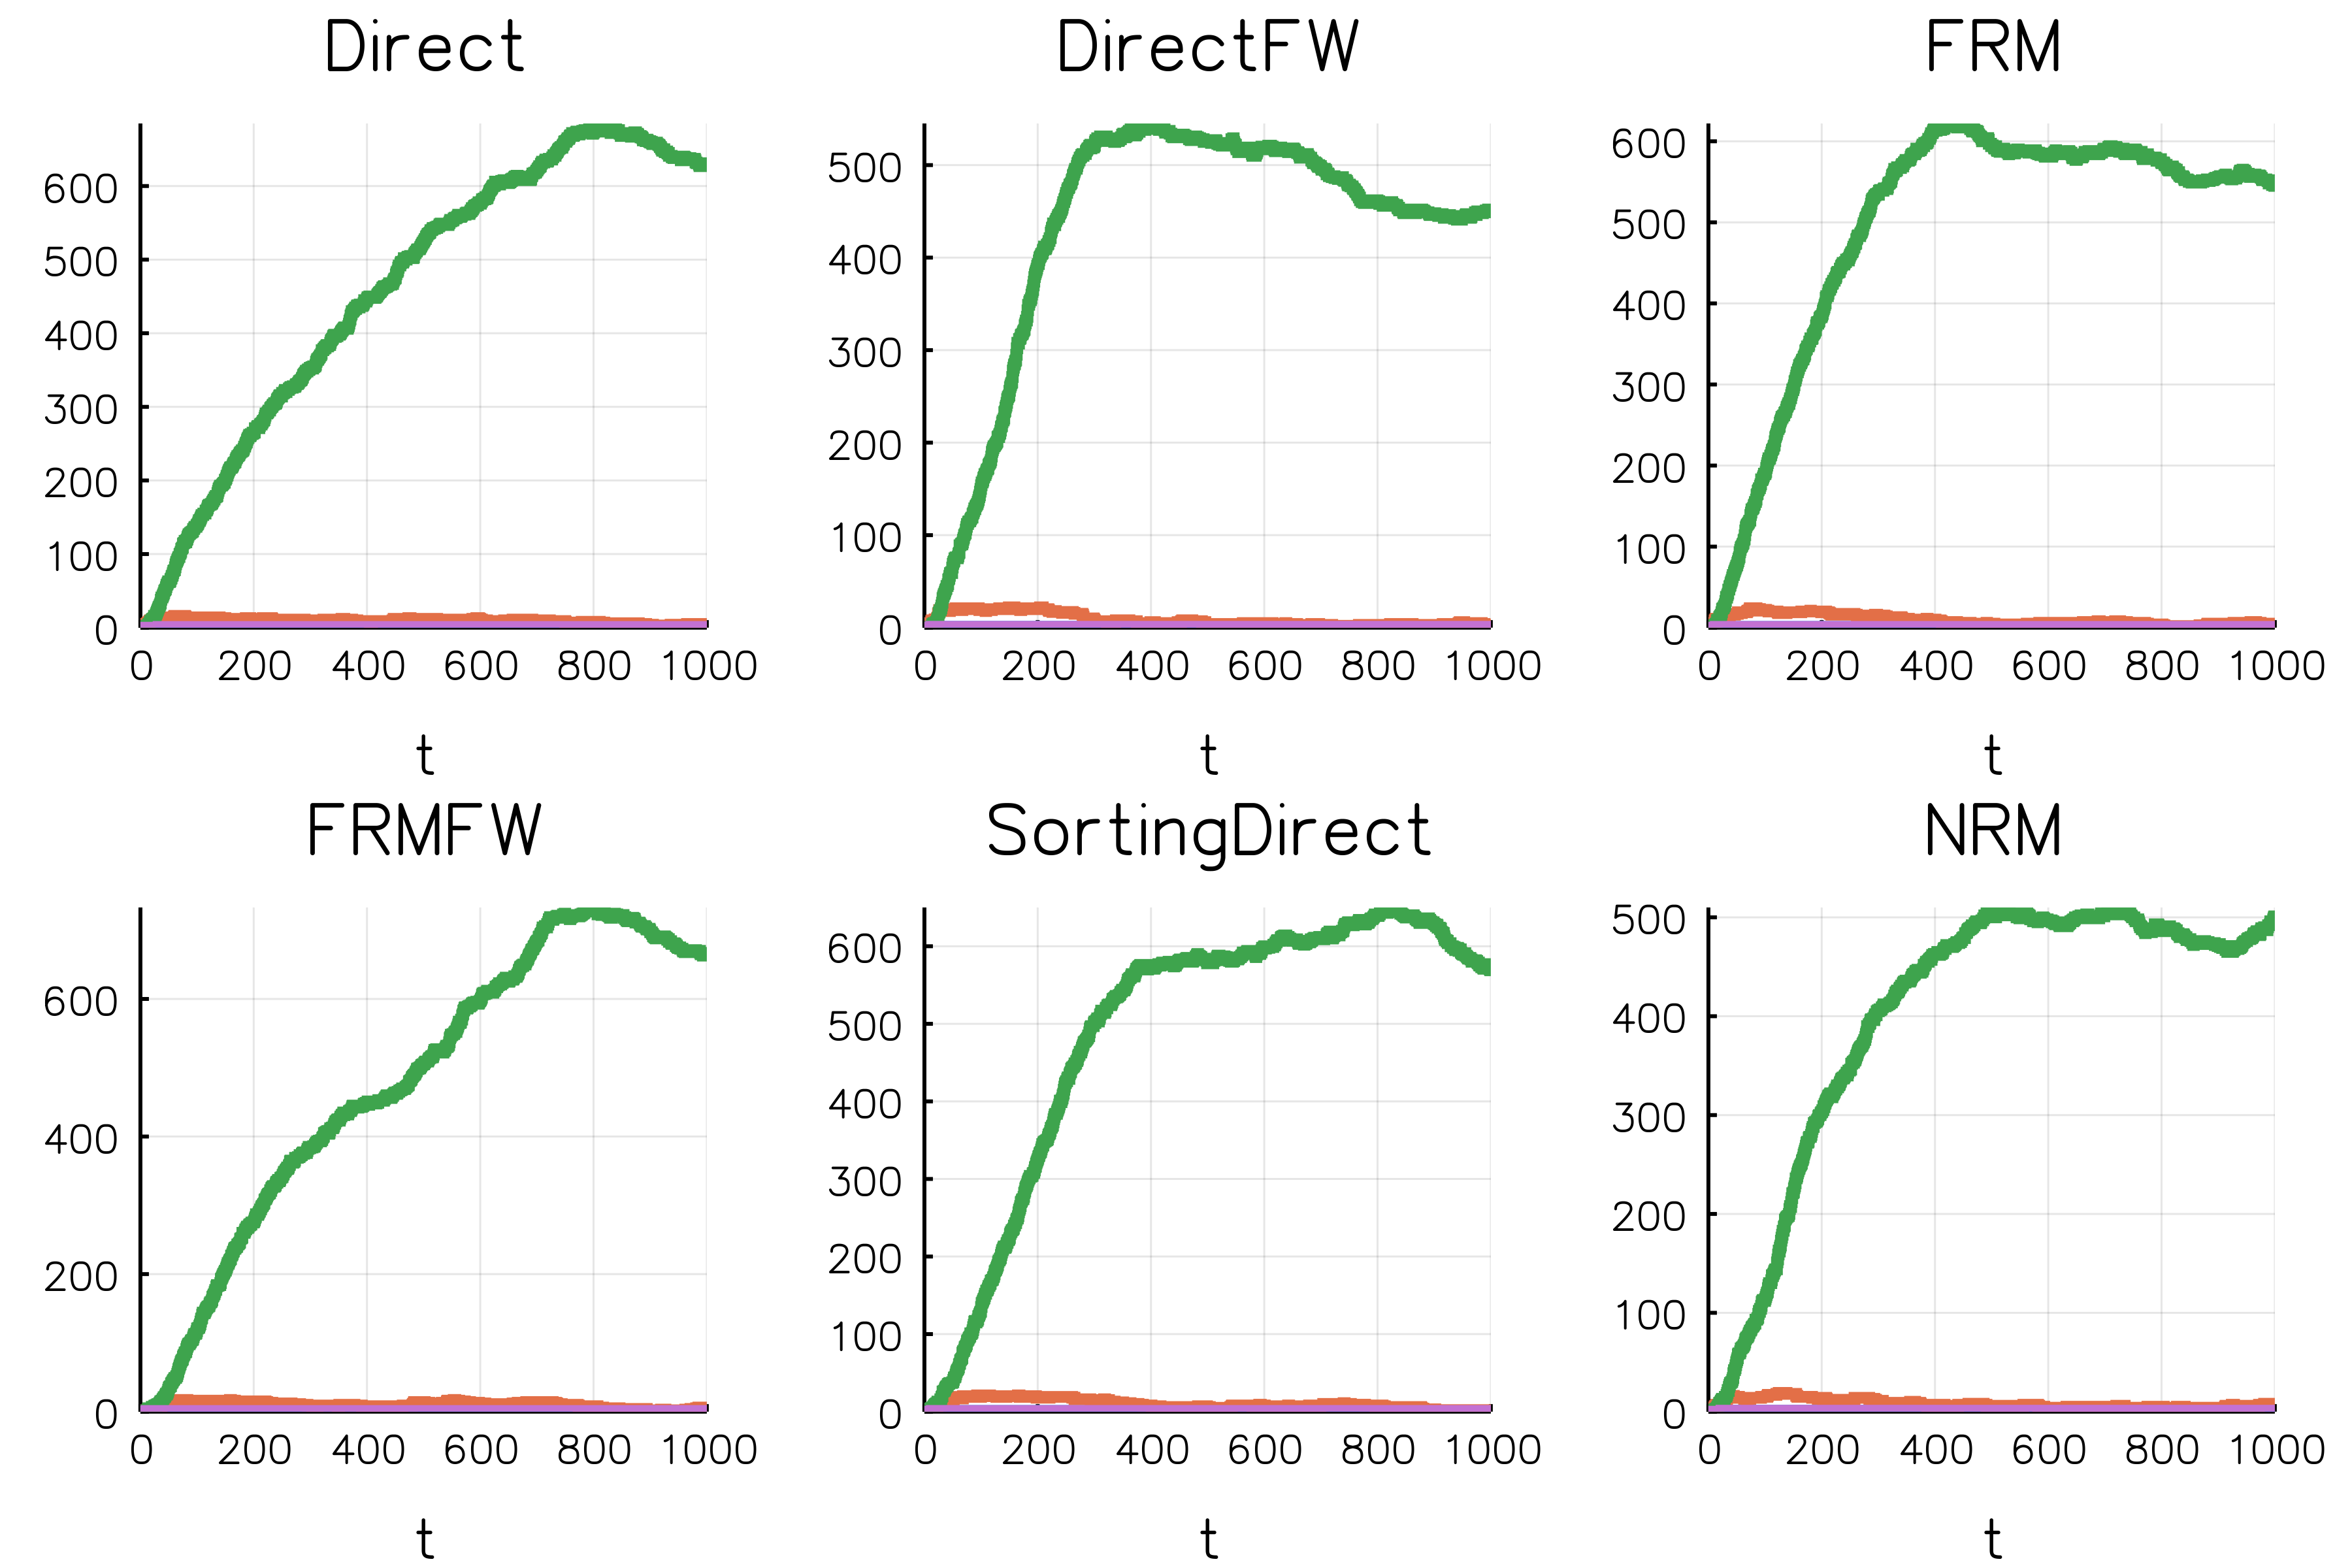

In [22]:
p = []
for (i,method) in enumerate(methods)
    jump_prob = JumpProblem(prob, method, rn, save_positions=(false,false))
    sol = solve(jump_prob, SSAStepper(), saveat=tf/1000.)
    push!(p, plot(sol,title=shortlabels[i],leg=false,format=fmt))
end
plot(p...,format=fmt)

# Benchmarking performance of the methods

In [3]:
function run_benchmark!(t, jump_prob, stepper)
    sol = solve(jump_prob, stepper)
    @inbounds for i in 1:length(t)
        t[i] = @elapsed (sol = solve(jump_prob, stepper))
    end
end

run_benchmark! (generic function with 1 method)

In [10]:
nsims = 500
benchmarks = Vector{Vector{Float64}}()
gc()
for method in methods
    jump_prob = JumpProblem(prob, method, rn, save_positions=(false,false))
    stepper = SSAStepper()
    t = Vector{Float64}(nsims)
    run_benchmark!(t, jump_prob, stepper)
    push!(benchmarks, t)
end

In [11]:
medtimes = Vector{Float64}(length(methods))
stdtimes = Vector{Float64}(length(methods))
avgtimes = Vector{Float64}(length(methods))
for i in 1:length(methods)
    medtimes[i] = median(benchmarks[i])
    avgtimes[i] = mean(benchmarks[i])
    stdtimes[i] = std(benchmarks[i])
end
using DataFrames

df = DataFrame(names=shortlabels,medtimes=medtimes,relmedtimes=(medtimes/medtimes[1]),avgtimes=avgtimes, std=stdtimes, cv=stdtimes./avgtimes)

,names,medtimes,relmedtimes,avgtimes,std,cv
1,Direct,0.000949116,1.0,0.00117981,0.00157155,1.33203
2,DirectFW,0.000985587,1.03843,0.00120352,0.00157206,1.30622
3,FRM,0.00110745,1.16682,0.00138731,0.00169272,1.22014
4,FRMFW,0.00112401,1.18427,0.00145019,0.00175852,1.21261
5,SortingDirect,0.000855923,0.901811,0.00105453,0.0014376,1.36326
6,NRM,0.00158797,1.6731,0.00189592,0.00198437,1.04665


Using `BenchmarkTools` below, but the results are not necessarily consistent.

In [23]:
using BenchmarkTools
benchmarks = []
# turn off saving solution
for method in methods
    jump_prob = JumpProblem(prob, method, rn, save_positions=(false,false))
    sol = solve(jump_prob, SSAStepper())
    push!(benchmarks, @benchmark solve($jump_prob, $SSAStepper()))
end

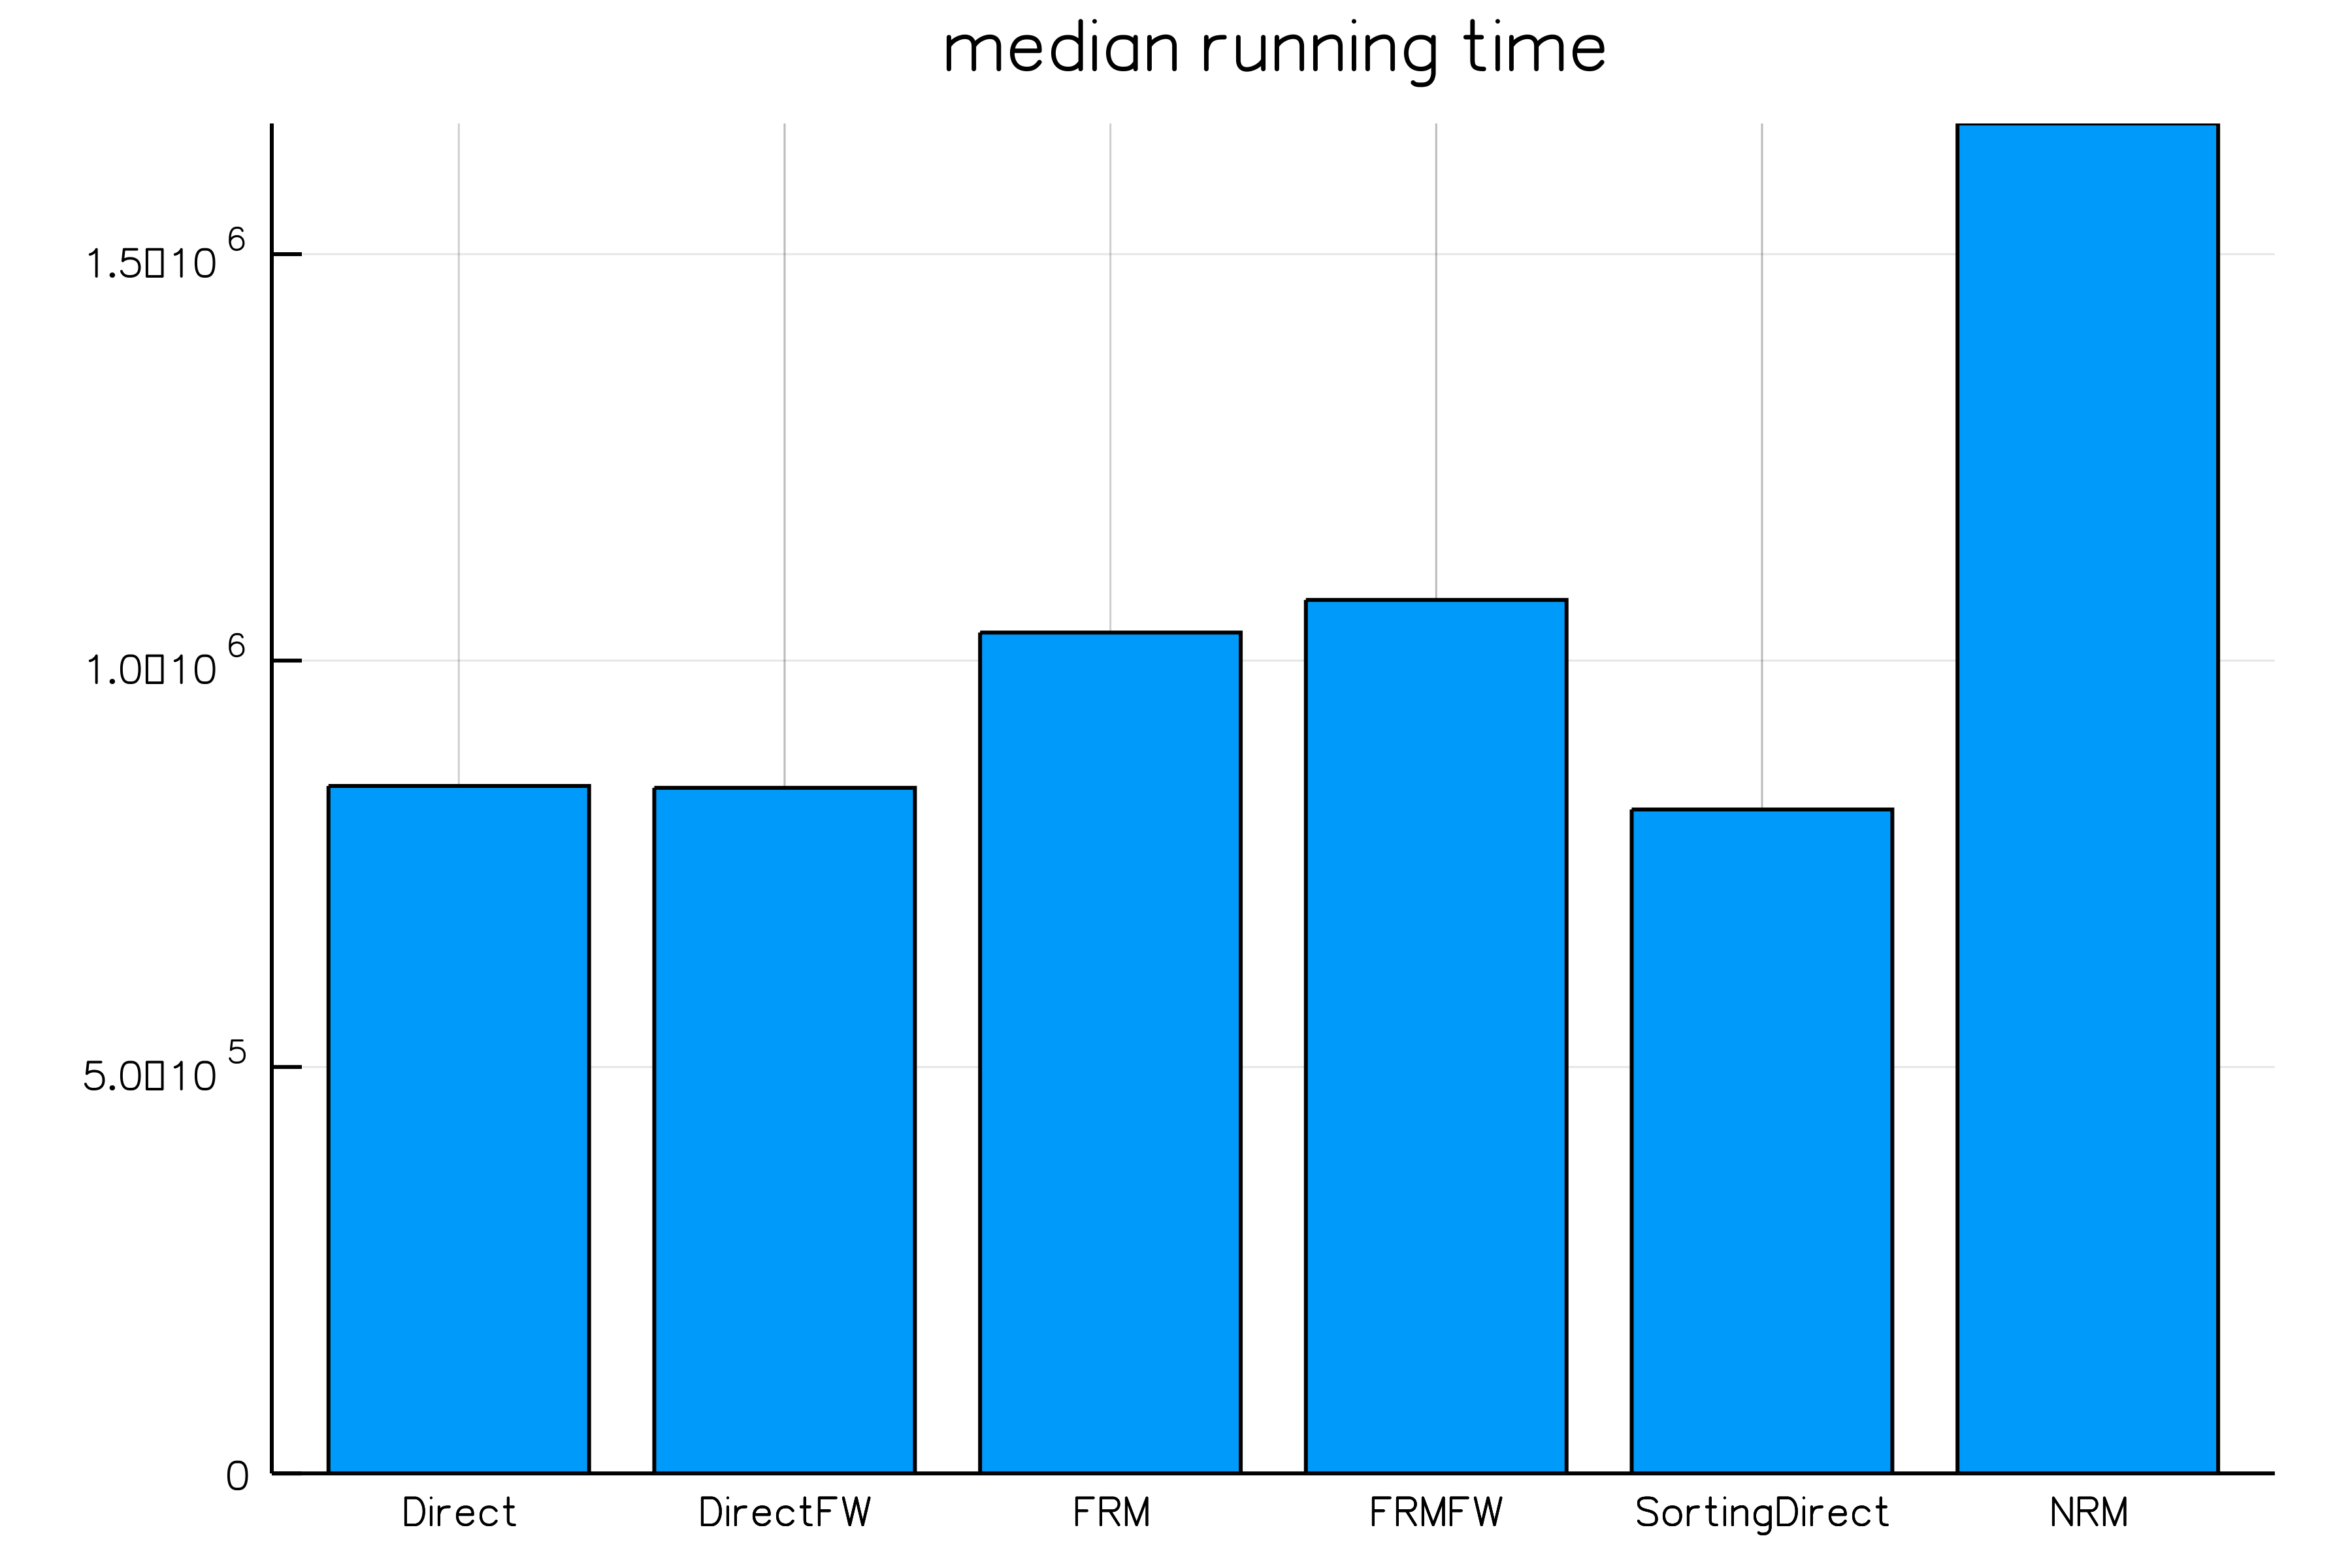

In [24]:
medtimes = [median(b.times) for b in benchmarks]
bar(shortlabels,medtimes,title="median running time",leg=false,format=fmt)

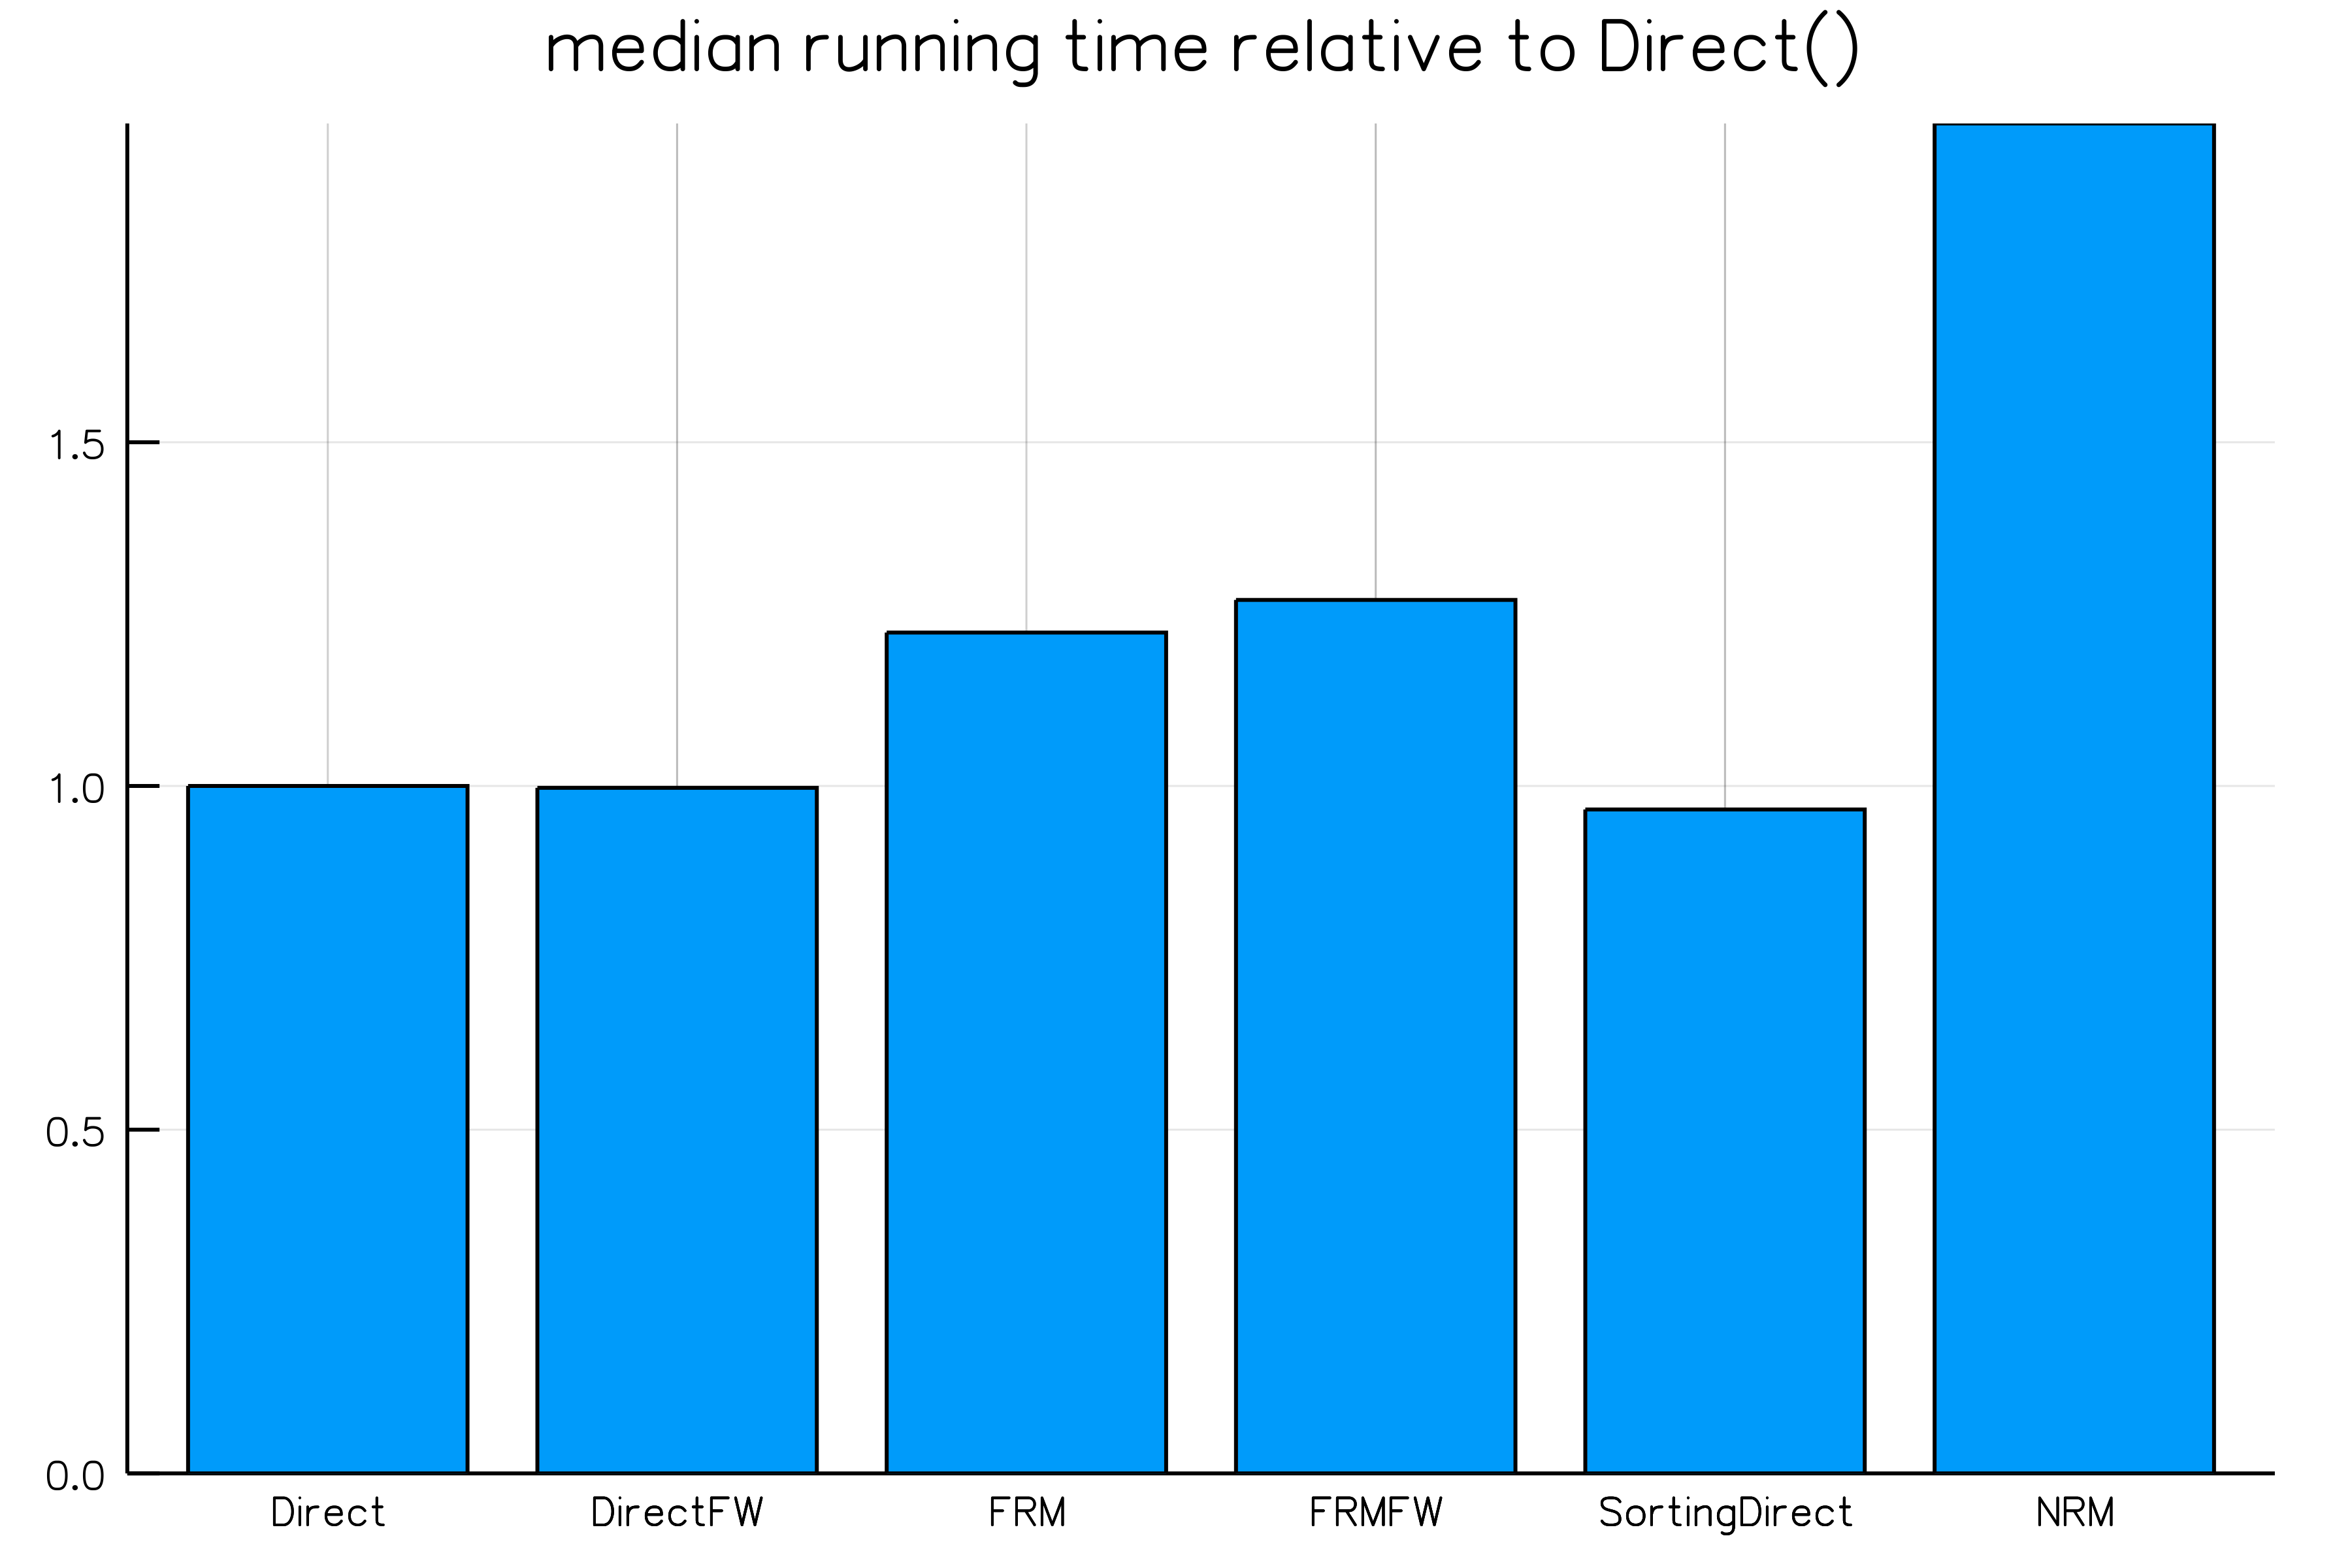

In [25]:
relmed = medtimes / medtimes[1]
bar(shortlabels,relmed,title="median running time relative to Direct()",leg=false,format=fmt)

In [37]:
using DataFrames
# convert times to units of ms
df = DataFrame(names=shortlabels,medtimes=(medtimes/1e6),relmedtimes=relmed)

,names,medtimes,relmedtimes
1,Direct,0.845738,1.0
2,DirectFW,0.843456,0.997301
3,FRM,1.03448,1.22317
4,FRMFW,1.07461,1.27061
5,SortingDirect,0.816822,0.96581
6,NRM,1.6608,1.96373
